In [1]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


# python lib

In [33]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib
import xgboost
from sklearn.metrics import mean_squared_error

# from google.colab.patches import cv2_imshow

# feature selection

In [5]:
feature_selection = [4 ,10 ,9, 4, 152, 365, 136, 34, 356,159,263]

# extracting data

In [69]:

mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)
data = []
targets = []
dir_path = r"C:\Users\DELL\Desktop\ITI\DS & ALG\ml_project\AFLW2000"
images = glob.glob(os.path.join(dir_path, "*.mat"))
for image_path in images:
    image_name = Path(image_path).stem
    image = cv2.imread(os.path.join(dir_path, f"{image_name}.jpg"))
    results = mp_face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        image_landmarks = []
        for face_landmarks in results.multi_face_landmarks:
            
            for index,landmark in enumerate(face_landmarks.landmark):
                
                if index in feature_selection:
                    nose=face_landmarks.landmark[4]
                    chin=face_landmarks.landmark[152]
                    E_Dist=np.sqrt((nose.x-chin.x)**2+(nose.y-chin.y)**2)
                    relative_x = float(((landmark.x-nose.x)/(E_Dist)))
                    relative_y = float(((landmark.y-nose.y)/(E_Dist)) )
                    # Append landmark coordinates to the list
                    image_landmarks.extend([relative_x, relative_y])
            
        # Append facial landmarks to the data list
        data.append(image_landmarks)
        # Load corresponding .mat file to extract roll, pitch, and yaw
        mat_data = sio.loadmat(os.path.join(dir_path, f"{image_name}.mat"))
        # Extract pose parameters (roll, pitch, yaw) and append to targets list
        pose_para = mat_data["Pose_Para"][0][:3]
        targets.append(pose_para)


# Convert lists to numpy arrays
data = np.array(data)
targets = np.array(targets)

# Convert data to a DataFrame
num_landmarks = data.shape[1] // 2  # Number of landmark points
columns = [f'X-{i//2 + 1}' if i % 2 == 0 else f'Y-{i//2 + 1}' for i in range(data.shape[1])]
df = pd.DataFrame(data, columns=columns)

# Add roll, pitch, and yaw columns to the DataFrame
df['roll'] = targets[:, 2]
df['pitch'] = targets[:, 0]
df['yaw'] = targets[:, 1]

# Save DataFrame to a CSV file
df.dropna().to_csv('face_LM.csv', index=False)


In [41]:
data=pd.read_csv('face_LM.csv')
data

,X-1,Y-1,X-2,Y-2,X-3,Y-3,X-4,Y-4,X-5,Y-5,...,Y-7,X-8,Y-8,X-9,Y-9,X-10,Y-10,roll,pitch,yaw
0,0.0,0.0,0.096899,-0.972722,0.147899,-1.575751,-1.000333,-0.944345,-0.698777,0.377170,...,-0.920087,0.866717,-0.713147,1.295556,-0.806055,0.767215,0.546522,0.085676,-0.399231,0.018227
1,0.0,0.0,0.296142,-0.625203,0.381924,-0.979260,0.438408,-0.335787,0.432946,0.626179,...,-0.471368,0.919562,-0.386925,1.730117,-0.280789,1.216682,0.810092,0.300959,0.470065,1.189533
2,0.0,0.0,-0.065465,-0.700769,-0.088337,-1.131464,-1.113427,-0.450022,-0.812354,0.636499,...,-0.536205,0.506196,-0.508632,0.731158,-0.500895,0.515759,0.582014,-0.236852,-0.184650,0.881137
3,0.0,0.0,-0.165413,-0.876479,-0.263844,-1.256033,-0.591530,-0.459033,0.007565,0.470100,...,-0.596701,0.687161,-0.889078,1.245206,-1.123033,1.264378,0.158018,-0.373374,-0.175379,0.299208
4,0.0,0.0,-0.096944,-0.605974,-0.174720,-1.018714,-0.793409,-0.145923,-0.361057,0.820514,...,-0.398144,0.480808,-0.517870,0.859825,-0.508187,0.804195,0.569856,-0.220662,-0.026812,0.011965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.0,0.0,-0.074253,-0.861500,-0.083576,-1.391350,-1.413331,-0.588985,-1.103546,0.633563,...,-0.688915,0.479723,-0.623612,0.577092,-0.652517,0.285551,0.542866,0.038554,-0.306358,-0.283822
1849,0.0,0.0,-0.042157,-0.896667,-0.024175,-1.372538,-1.293017,-0.708662,-1.079780,0.545609,...,-0.736067,0.433188,-0.624326,0.522066,-0.673757,0.207376,0.514444,0.122791,-0.367547,-0.429723
1850,0.0,0.0,0.152053,-0.631080,0.239103,-0.967647,-0.727323,-0.573784,-0.814660,0.475084,...,-0.559331,0.550121,-0.256933,0.716649,-0.178843,0.277643,0.792134,-0.108536,-0.156035,0.567114
1851,0.0,0.0,0.089893,-0.978031,0.146871,-1.587424,-1.135646,-0.859156,-0.876771,0.489004,...,-0.848849,0.843511,-0.636305,1.173784,-0.686436,0.635503,0.631023,0.105118,-0.197102,-0.070430


In [42]:
m,n=data.shape
features=data.iloc[:,:n-3]
roll=data['roll']
pitch=data['pitch']
yaw=data['yaw']


# data spliting

In [43]:
roll_features_train, roll_features_validation_test, roll_labels_train, roll_labels_validation_test = train_test_split(
    features,roll , test_size=0.2, random_state=42)

roll_features_validation, roll_features_test, roll_labels_validation, roll_labels_test = train_test_split(
    roll_features_validation_test, roll_labels_validation_test, test_size=0.5, random_state=42)


pitch_features_train, pitch_features_validation_test, pitch_labels_train, pitch_labels_validation_test = train_test_split(
    features, pitch, test_size=0.2, random_state=42)

pitch_features_validation, pitch_features_test, pitch_labels_validation, pitch_labels_test = train_test_split(
    pitch_features_validation_test, pitch_labels_validation_test, test_size=0.5, random_state=42)


yaw_features_train, yaw_features_validation_test, yaw_labels_train, yaw_labels_validation_test = train_test_split(
    features, yaw, test_size=0.2, random_state=42)

yaw_features_validation, yaw_features_test, yaw_labels_validation, yaw_labels_test = train_test_split(
    yaw_features_validation_test, yaw_labels_validation_test, test_size=0.5, random_state=42)

# SVR training

In [38]:
svr_roll = SVR(C=10, epsilon=0.000001).fit(roll_features_train, roll_labels_train)

svr_pitch = SVR().fit(pitch_features_train, pitch_labels_train)

svr_yaw = SVR(C=15, epsilon=0.000001).fit(yaw_features_train, yaw_labels_train)

In [44]:
joblib.dump(svr_pitch, 'svr_pitch_model.pkl')
joblib.dump(svr_yaw, 'svr_yaw_model.pkl')
joblib.dump(svr_roll, 'svr_roll_model.pkl')

['svr_roll_model.pkl']

# score

In [39]:
roll_val_score = svr_roll.score(roll_features_validation, roll_labels_validation)
roll_test_scor = svr_roll.score(roll_features_test, roll_labels_test)

pitch_val_score = svr_pitch.score(pitch_features_validation, pitch_labels_validation)
pitch_test_scor = svr_pitch.score(pitch_features_test, pitch_labels_test)

yaw_val_score = svr_yaw.score(yaw_features_validation, yaw_labels_validation)
yaw_test_scor = svr_yaw.score(yaw_features_test, yaw_labels_test)

print("roll Validation score: ", roll_val_score)
print("roll Test score: ", roll_test_scor)
print('______________________________')
print("pitch Validation score: ", pitch_val_score)
print("pitch Test score: ", pitch_test_scor)
print('______________________________')
print("yaw Validation score: ", yaw_val_score)
print("yaw Test score: ", yaw_test_scor)

roll Validation score:  0.8508368040053566
roll Test score:  0.9365101691812759
______________________________
pitch Validation score:  0.7394721265222777
pitch Test score:  0.8058336197181952
______________________________
yaw Validation score:  0.9240153523322825
yaw Test score:  0.9689041121740752


### MSE

In [40]:
roll_val_pred = svr_roll.predict(roll_features_validation)
roll_test_pred = svr_roll.predict(roll_features_test)

pitch_val_pred = svr_pitch.predict(pitch_features_validation)
pitch_test_pred = svr_pitch.predict(pitch_features_test)

yaw_val_pred = svr_yaw.predict(yaw_features_validation)
yaw_test_pred = svr_yaw.predict(yaw_features_test)

roll_val_mse = mean_squared_error(roll_labels_validation, roll_val_pred)
roll_test_mse = mean_squared_error(roll_labels_test, roll_test_pred)

pitch_val_mse = mean_squared_error(pitch_labels_validation, pitch_val_pred)
pitch_test_mse = mean_squared_error(pitch_labels_test, pitch_test_pred)

yaw_val_mse = mean_squared_error(yaw_labels_validation, yaw_val_pred)
yaw_test_mse = mean_squared_error(yaw_labels_test, yaw_test_pred)

print("Roll Validation MSE:", roll_val_mse)
print("Roll Test MSE:", roll_test_mse)
print('______________________________')
print("Pitch Validation MSE:", pitch_val_mse)
print("Pitch Test MSE:", pitch_test_mse)
print('______________________________')
print("Yaw Validation MSE:", yaw_val_mse)
print("Yaw Test MSE:", yaw_test_mse)

Roll Validation MSE: 0.015474222336794255
Roll Test MSE: 0.006208602732629161
______________________________
Pitch Validation MSE: 0.02127038156805454
Pitch Test MSE: 0.012499931416312997
______________________________
Yaw Validation MSE: 0.01904385245942803
Yaw Test MSE: 0.0078896612967273


# grid search

In [66]:
# param_grid = {
#     'kernel': ['rbf'],
#     'C': np.arange(10, 20, 0.2),
#     'epsilon': np.arange(0.000001,0.00001,0.00001) 
# }
# # Initialize SVR model
# svr = SVR()

# # Perform GridSearchCV
# grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(pitch_features_train, pitch_labels_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score (Negative Mean Squared Error):", best_score)

# drawing fun

In [45]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# web cam

In [46]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False)

video = cv2.VideoCapture(0)

while True:
    ret, frame = video.read()
    frame=cv2.flip(frame,1)
    if ret:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                image_landmarks = []
                nose = face_landmarks.landmark[4]
                chin = face_landmarks.landmark[152]
                E_Dist = np.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2 )
                for index,landmark in enumerate(face_landmarks.landmark):
                    if index in feature_selection:
                        relative_x = float(((landmark.x - nose.x) / E_Dist))
                        relative_y = float(((landmark.y - nose.y) / E_Dist))
                        image_landmarks.extend([relative_x, relative_y])

                image_landmarks = np.array(image_landmarks).reshape(1, -1)

                columns = [f'X-{i//2 + 1}' if i % 2 == 0 else f'Y-{i//2 + 1}' for i in range(image_landmarks.shape[1])]
                image_landmarks_df = pd.DataFrame(image_landmarks, columns=columns)

                # Predict roll, pitch, yaw
                pred_roll = svr_roll.predict(image_landmarks_df)
                pred_pitch = svr_pitch.predict(image_landmarks_df)
                pred_yaw = svr_yaw.predict(image_landmarks_df)

                cv2.putText(frame, "Pitch: "+str(round(pred_pitch[0]*180/3.14 , 2)), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2) 
                cv2.putText(frame, "Roll: "+str(round(pred_roll[0]*180/3.14 ,2 )), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(frame, "Yaw: "+str(round(pred_yaw[0]*180/3.14 , 2)), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2)

                draw_x = int(nose.x * frame.shape[1])
                draw_y = int(nose.y * frame.shape[0])

                frame = draw_axis(frame, pred_pitch, pred_yaw, pred_roll, draw_x, draw_y)

            cv2.imshow('Frame', frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break

video.release()
cv2.destroyAllWindows()

# image

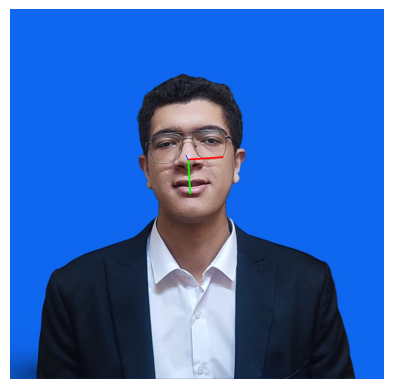

In [54]:
img1 = cv2.imread(r"C:\Users\DELL\Desktop\WhatsApp Image 2024-02-15 at 09.40.43_95694e3b.jpg")
results = face_mesh.process(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

if results.multi_face_landmarks:
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidean = np.sqrt((nose.x - chin.x) ** 2 + (nose.y - chin.y) ** 2)
        for index, landmark in enumerate(face.landmark):
            if index in feature_selection:
                relative_x = float(((landmark.x - nose.x) / euclidean))
                relative_y = float(((landmark.y - nose.y) / euclidean))
                landmarks.extend([relative_x, relative_y])

        landmarks = np.array(landmarks).reshape(1, -1)

        pitch = svr_pitch.predict(landmarks)
        yaw = svr_yaw.predict(landmarks)
        roll = svr_roll.predict(landmarks)
        draw_x = (nose.x * frame.shape[1])
        draw_y = (nose.y * frame.shape[0])
        frame = draw_axis(img1, pitch, yaw, roll, tdx=draw_x, tdy=draw_y)

        # Plot the image
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()


# selected points

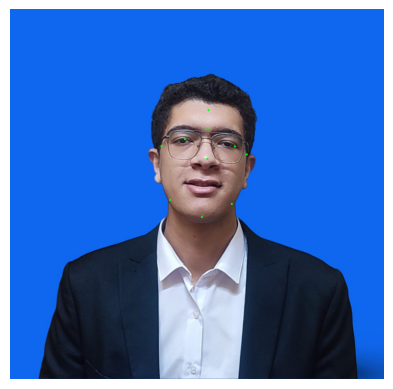

In [62]:

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

img = cv2.imread(r"C:\Users\DELL\Desktop\WhatsApp Image 2024-02-15 at 09.40.43_95694e3b.jpg")
img = cv2.flip(img, 1)

results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for index, landmark in enumerate(face_landmarks.landmark):
            if index in feature_selection:
                x = int(landmark.x * img.shape[1])
                y = int(landmark.y * img.shape[0])
                cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



# video 

In [63]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False)

video = cv2.VideoCapture(r'C:\Users\DELL\Desktop\ITI\DS & ALG\ml_project\WhatsApp Video 2024-03-10 at 21.46.52_19f4affd.mp4')
fourcc = cv2.VideoWriter_fourcc(*'AVC1')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (int(video.get(3)), int(video.get(4))))

while True:
    ret, frame = video.read()
    # frame=cv2.flip(frame,1)
    if ret:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                image_landmarks = []
                nose = face_landmarks.landmark[4]
                chin = face_landmarks.landmark[152]
                E_Dist = np.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2 )
                for index,landmark in enumerate(face_landmarks.landmark):
                    if index in feature_selection:
                        relative_x = float(((landmark.x - nose.x) / E_Dist))
                        relative_y = float(((landmark.y - nose.y) / E_Dist))
                        image_landmarks.extend([relative_x, relative_y])

                image_landmarks = np.array(image_landmarks).reshape(1, -1)

                columns = [f'X-{i//2 + 1}' if i % 2 == 0 else f'Y-{i//2 + 1}' for i in range(image_landmarks.shape[1])]
                image_landmarks_df = pd.DataFrame(image_landmarks, columns=columns)

                # Predict roll, pitch, yaw
                pred_roll = svr_roll.predict(image_landmarks_df)
                pred_pitch = svr_pitch.predict(image_landmarks_df)
                pred_yaw = svr_yaw.predict(image_landmarks_df)

                cv2.putText(frame, "Pitch: "+str(round(pred_pitch[0]*180/3.14 , 2)), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2) 
                cv2.putText(frame, "Roll: "+str(round(pred_roll[0]*180/3.14 ,2 )), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(frame, "Yaw: "+str(round(pred_yaw[0]*180/3.14 , 2)), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2)

                draw_x = float(nose.x * frame.shape[1])
                draw_y = float(nose.y * frame.shape[0])

                frame = draw_axis(frame, pred_pitch, pred_yaw, pred_roll, draw_x, draw_y)

            cv2.imshow('Frame', frame)
            out.write(frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break

video.release()
cv2.destroyAllWindows()